# Sentinel-1/ Sentinel-2 GIF generator

In [1]:
# standard imports to get started
import datetime
import shapely
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib.animation import PillowWriter
import ipywidgets as ipyw
import ipyleaflet

import descarteslabs as dl
from descarteslabs.catalog import Product, Image, ImageCollection, properties as p
from descarteslabs import dynamic_compute as dc

### 1. Utils for search insar product and GIF generation

In [2]:
def get_images(geoctx, orbit=None, btemp=12, 
               t0="2021-01-01", t1="2022-01-01",
               bands="coherence", group_by="day"):
    """
    Function to search for S1/ S2 images
    """
    
    # Make strings out of btemp and orbit
    btemp = str(btemp)
    if orbit:
        orbit = "{:03d}".format(orbit)
       
    # Then create image collection
    if bands in ["coherence", "phase"]:
        # This is for InSAR
        insar_ic = Product.get("esa:sentinel-1:ifg:v1").images().filter(
            t0 <= p.acquired < t1
        ).intersects(geoctx.geometry)

    elif bands in ["vv", "vh"]:
        # This for backscatter
        insar_ic = Product.get(
            "esa:sentinel-1:sigma0v:v1"
        ).images().filter(
            t0 <= p.acquired < t1
        ).intersects(geoctx.geometry)
    elif bands in ["rgb"]:
        # This is for Sentinel-2 optical
        # Change cloud fraction as needed for cleaner GIFs as needed
        insar_ic = Product.get(
            "esa:sentinel-2:l2a:v1"
        ).images().filter(
            t0 <= p.acquired < t1
        ).filter(
            p.cloud_fraction < 0.25
        ).intersects(
            geoctx.geometry
        )
    
    # If relative orbit is not None
    # This is for S1 only. Do not provide this for S2
    if orbit:
        insar_ic = insar_ic.collect()
        insar_ic = insar_ic.filter(
           lambda x: x.id.split(":")[-1].split("-")[4] == orbit
        )
        
    # Temporal baseline
    if bands in ["coherence", "phase"]:
        insar_ic = insar_ic.filter(
            lambda x: str(x.extra_properties["temp_baseline"]) == btemp
        )
    
    # Finally group by and mosaic
    if group_by == "day":
        group_by_func = lambda x: (x.acquired.year, x.acquired.month, x.acquired.day)
    elif group_by == "month":
        group_by_func = lambda x: (x.acquired.year, x.acquired.month)
    
    # Group by month for longer timespans and bigger areas for speed
    groups = {}
    for img in insar_ic:
        key = group_by_func(img)
        if key not in groups:
            groups[key] = []
            
        groups[key].append(img)

    return groups

In [3]:
class AnimatedGif:
    """
    GIF helper
    """
    def __init__(self, size=(640, 480)):
        self.fig = plt.figure()
        self.fig.set_size_inches(size[0] / 100, size[1] / 100)
        ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.images = []
 
    def add(self, image, label='', clim=[-0.2, 0.8], cmap="jet", **fontargs):
        if image.shape[0] == 1:
            plt_im = plt.imshow(image[0], cmap=cmap, vmin=clim[0], vmax=clim[1], animated=True)
        else:
            plt_im = plt.imshow(np.moveaxis(image, 0, -1)/clim[1],  animated=True)
        plt_txt = plt.text(10, 310, label, **fontargs)
        self.images.append([plt_im, plt_txt])
 
    def save(self, filename):
        animation = anim.ArtistAnimation(self.fig, self.images)
        animation.save(filename, writer=PillowWriter(fps=5))

In [11]:
def make_img_coll(imglist):   
    coll = ImageCollection()
    for img in imglist:
        coll.append(img)
        
    return coll

def make_gif(stack, geoctx, outname, layer="coherence"):
    if layer=="coherence":
        clim = [0., 1.]
        cmap = "gray"
        bands = "coherence"
    elif layer=="phase":
        clim = [-np.pi, np.pi]
        cmap = "hsv"
        bands = "phase"
    elif layer in ["vv", "vh"]:
        # In dB
        clim = [-20., 1.]
        cmap = "gray"
        bands = layer
    elif layer in ["rgb"]:
        clim = [0.0, 0.3]
        cmap = None
        bands = ["red", "green", "blue"]
    
    try:
        # If grouping by date
        dates = ["{}-{:02d}-{:02d}".format(*x) for x in stack]
    except:
        # If grouping by month
        dates = ["{}-{:02d}".format(*x) for x in stack]

    # We don't know the size yet. So start iterating
    count = 0
    fontargs = {"fontsize": "large",
                "color": "red",
                "backgroundcolor": "white"}
    
    for key, imglist in stack.items():
        imcoll = make_img_coll(imglist)
        data = imcoll.mosaic(bands, geocontext=geoctx, scaling="physical")
        data = data.filled(0.)
        print(data.min(), data.max(), data.shape)
        if count == 0:
            m = data.shape[-2]
            n = data.shape[-1]
            animated_gif = AnimatedGif(size=(m, n))
              
        label = dates[count]
        animated_gif.add(data,
                         label=label,
                         clim=clim,
                         cmap=cmap, **fontargs)
        count += 1
 
    animated_gif.save(outname)

### 2. Setup AOI using viewport

In [5]:
m = dc.map
m.map.center = (35.687, -105.9378)
m.map.zoom = 14

In [6]:
m


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


In [7]:
# Scroll around and ensure extent is right before running this cell
poly = shapely.geometry.box(*(dc.map.geocontext().bounds))
zoom = dc.map.zoom
poly.wkt

'POLYGON ((-105.92425732275922 35.67002270782721, -105.92425732275922 35.70421690671906, -105.95983414313275 35.70421690671906, -105.95983414313275 35.67002270782721, -105.92425732275922 35.67002270782721))'

### 3. Identify unique S1 burst footprints in viewport

If you know the track number, just skip this section and use the track number in the next section

In [8]:
# Search for footprints that intersect with AOI
footprints = Product.get("esa:sentinel-1:burst_index:v1").images().intersects(poly)
print("Number of burst footprints: ", footprints.count())
print("S1 Tracks: ", set([x.id.split(":")[-1].split("-")[0] for x in footprints]))

Number of burst footprints:  5
S1 Tracks:  {'158', '151', '056'}


### 4. Create GIF

In [9]:
# This sets up projection and resolution at which data will be pulled in
epsg=32601 + int((poly.centroid.xy[1][0] + 180)/6)
geoctx = dl.geo.AOI(geometry=poly, crs=f"EPSG:{epsg}", resolution=20., align_pixels=True)

In [10]:
# Pull in backscatter data
coll = get_images(geoctx, orbit=158, t0="2023-04-01", t1="2023-12-01", bands="vv", group_by="month")

-23.312164142647777 15.893991206643868 (1, 287, 272)
-22.423058133854422 16.03077674645823 (1, 287, 272)
-23.089887640449437 15.893991206643868 (1, 287, 272)
-23.26086956521739 15.757205666829506 (1, 287, 272)
-23.072789447972642 16.389838788470932 (1, 287, 272)
-24.06448461162677 16.184660478749393 (1, 287, 272)
-22.730825598436738 15.705911089399116 (1, 287, 272)
-23.585735222276504 15.34684904738642 (1, 287, 272)


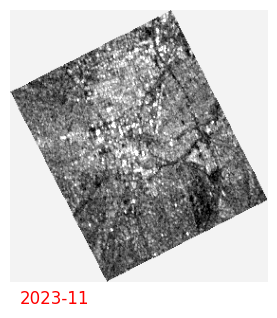

In [12]:
# Make the backscatter GIF
make_gif(coll, geoctx, "SantaFe_VV_T158_2022_2023.gif", layer="vv")

In [13]:
# Pull in coherence date
coll = get_images(geoctx, orbit=158, btemp=12, t0="2022-01-01", t1="2023-02-01", bands="coherence")

0.0 1.0 (1, 287, 272)
0.0 1.0 (1, 287, 272)
0.0 1.0 (1, 287, 272)
0.0 1.0 (1, 287, 272)
0.0 1.0 (1, 287, 272)


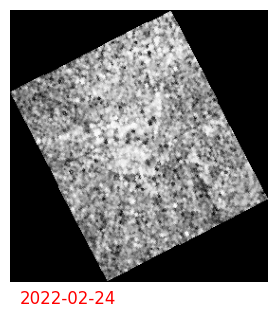

In [14]:
# Make coherence gif
make_gif(coll, geoctx, "SantaFe_coh_T158_2022_2023.gif", layer="coherence")

In [15]:
# Pull S2 data
coll = get_images(geoctx, t0="2022-01-01", t1="2023-02-01", bands="rgb", group_by="month")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-0.030200000000000005 1.208 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 0.9514 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.7608000000000001 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.052 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.1984000000000001 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.8568 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.1112 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.7672 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 1.2096 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 0.8904000000000001 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 0.9744 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 0.9864 (3, 287, 272)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 0.8472000000000001 (3, 287, 272)


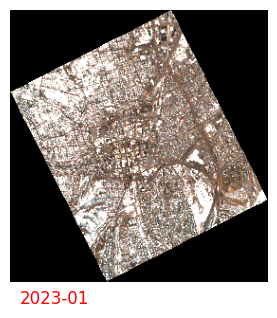

In [16]:
# Make S2 gif
make_gif(coll, geoctx, "SantaFe_S2_2022_2023.gif", layer="rgb")